# XGBoost Model Exploration

## Training

### Import Modules

In [78]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import os
import matplotlib.pyplot as plt

### Load datasets

In [79]:
# Load the dataset
train_df = pd.read_csv('./../../data/processed/train_dropped.csv')
test_df = pd.read_csv('./../../data/raw/test.csv')

# Separate features and target variable
X = train_df.drop(columns=['Price'])
y = train_df['Price']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
Numerical columns: ['id', 'Compartments', 'Weight Capacity (kg)']


### Preprocessing

In [80]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

### Pipeline

In [81]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        max_depth=7,              # Maximum tree depth for base learners.
        learning_rate=0.1,        # Boosting learning rate.
        n_estimators=100,         # Number of boosting rounds.
        subsample=0.8,            # Fraction of training data used per tree.
        colsample_bytree=0.8,     # Fraction of features used per tree.
        reg_alpha=0.0,            # L1 regularization term.
        reg_lambda=1.0,           # L2 regularization term.
        gamma=0,                  # Minimum loss reduction to make a split.
        min_child_weight=1        # Minimum sum of instance weight in a child.
    ))
])

### Grid Search

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'model__max_depth': [2, 3, 4],
    'model__learning_rate': [0.008, 0.01, 0.012],
    'model__n_estimators': [400, 500, 600],
    'model__subsample': [0.5, 0.55, 0.6],
    'model__colsample_bytree': [0.4, 0.45, 0.5],
    # 'model__reg_alpha': [0.0, 0.1, 0.5],
    # 'model__reg_lambda': [0.8, 1.0, 1.2],
    # 'model__gamma': [0, 1, 2],
    # 'model__min_child_weight': [1, 3, 5]
}

# Wrap your pipeline in GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

# Fit grid search on the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\cjsta\miniconda3\envs\kaggle-Backpack-Prediction-Challenge\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Brand',
                                                                          'Material',
                                                                          'Size',
                                                                          'Laptop '
                                                                          'Compartment',
                                                                          'Waterproof',
                                                                          'Style',
                                                                          'Color'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsampl...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.4, 0.45, 0.5],
                         'model__learning_rate': [0.008, 0.01, 0.012],
                         'model__max_depth': [2, 3, 4],
                         'model__n_estimators': [500, 600, 700],
                         'model__subsample': [0.5, 0.55, 0.6]},
             scoring='neg_mean_squared_error', verbose=3)

## Model Evaluation
Visualize and print statistics about our best model from grid search.

### Grid Search Best Model

In [83]:
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Print out each parameter with its best value and the corresponding choices
print("Best parameters and their choices:")
for param, choices in param_grid.items():
    best_value = grid_search.best_params_.get(param, None)
    print(f"\t{param:<25} | Best: {str(best_value):<10} | Choices: {choices}")

Best RMSE: 38.936195107396244
Best parameters and their choices:
	model__max_depth          | Best: 2          | Choices: [2, 3, 4]
	model__learning_rate      | Best: 0.012      | Choices: [0.008, 0.01, 0.012]
	model__n_estimators       | Best: 500        | Choices: [500, 600, 700]
	model__subsample          | Best: 0.55       | Choices: [0.5, 0.55, 0.6]
	model__colsample_bytree   | Best: 0.4        | Choices: [0.4, 0.45, 0.5]


### Feature Importance
Notice that there are 27 features, unnamed, in the plot below. This is because one-hot encoding is dissecting the categorical features into binary features. So a feature with 5 categorical values turns into 5 seperate binary features.

<Figure size 1000x600 with 0 Axes>

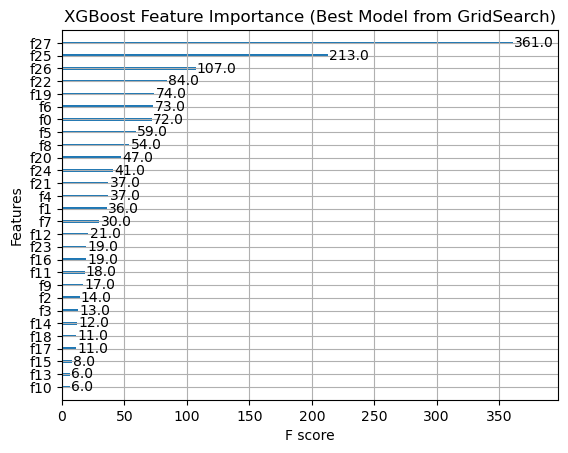

In [84]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming grid_search is your fitted GridSearchCV object
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['model']

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model)
plt.title("XGBoost Feature Importance (Best Model from GridSearch)")
plt.show()

### Generate Submission
Run the best model on `test.csv` and generate a CSV file in the Kaggle format.

In [85]:
# Predict on test data
y_pred_test = grid_search.predict(test_df)

# Create a submission DataFrame with only the 'id' and predicted 'Price'
submission = pd.DataFrame({
    'id': test_df['id'],
    'Price': y_pred_test
})

# Define the base file path
file_path = os.path.join('..', '..', 'submissions', 'xgboost_submission_1.csv')

# Check if the file exists; if so, append a number similar to Windows behavior
if os.path.exists(file_path):
    base, ext = os.path.splitext(file_path)
    i = 1
    new_file_path = f"{base} ({i}){ext}"
    # Increment the number until a non-existing file name is found
    while os.path.exists(new_file_path):
        i += 1
        new_file_path = f"{base} ({i}){ext}"
    file_path = new_file_path

# Save the submission to CSV using the determined file path
submission.to_csv(file_path, index=False)